# **SPAM vs. naiwny klasyfikator Bayesa**

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

Jak na ćwiczeniach o regresji logistycznej, podłączamy do projektu swój dysk Google'a, aby móc skorzystać z pobranego zestawu danych:

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')


Mounted at /content/drive/


In [3]:
folder = '/content/drive/' # podaj lokalizację pliku
os.chdir('/content/drive/My Drive/Uczenie Maszynowe')
print(os.getcwd())
print(os.listdir())

/content/drive/My Drive/Uczenie Maszynowe
['Maciej Krajewski - 02_Regresja_liniowa.ipynb', 'Maciej Krajewski - 02_reg_log_data.txt', 'Maciej Krajewski - 03_Regresja_logistyczna (2).ipynb', 'Maciej Krajewski - 03_reg_log_data.txt', 'Maciej Krajewski - 03_Regresja_logistyczna (1).ipynb', 'Maciej Krajewski - 03_Regresja_logistyczna.ipynb', 'test.txt', 'spam.csv']


Do pracy z danymi tekstowymi bardzo przydatna jest biblioteka [pandas](https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/).

In [4]:
import numpy as np
import pandas as pd

In [5]:
mails = pd.read_csv('spam.csv', encoding='latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Wyczyśćmy ten zbiór danych. Usuńmy niepotrzebne kolumny i zastąpmy nazwy 'v1' i 'v2' czymś bardziej przyjaznym.

In [6]:
mails = mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
mails = mails.rename(columns={"v1": "klasa", "v2": "tekst"})
mails.head()

,klasa,tekst
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Zobaczmy jak wyglądają przykładowe dane o numerze jakimkolwiek.

In [8]:
id = 57

Treść wiadomości:

In [9]:
mails['tekst'][id]

"Sorry, I'll call later in meeting."

Kategoria:

In [10]:
mails['klasa'][id]

'ham'

Ile mamy tych maili?

In [11]:
mails.shape

(5572, 2)

## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

To biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [12]:
!pip install wordcloud
import wordcloud

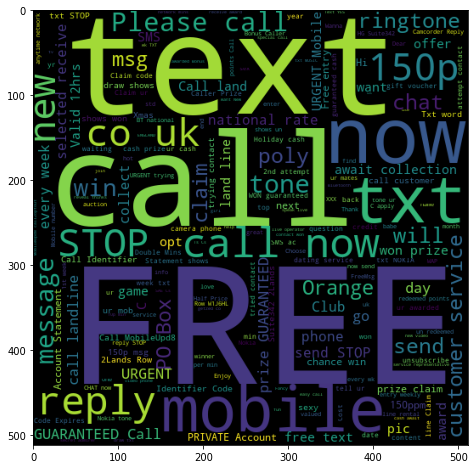

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = " ".join(list(mails [mails['klasa']=='spam']['tekst'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot)

Zrób to samo dla smsów nie będących spamem:

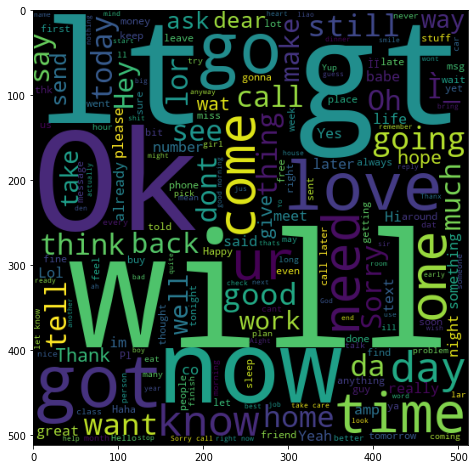

In [14]:
ham_words = " ".join(list(mails [mails['klasa']=='ham']['tekst'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)

plt.figure(figsize=(10,8))
plt.imshow(ham_plot)

Przygotujmy dane do treningu i testu klasyfikatora:

Przekodowujemy wiadomości na wektory cech.  Korzystamy z funkcji: [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [15]:
from sklearn.model_selection import train_test_split

X = mails.tekst
y = mails.klasa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X_train = vectorizer.transform(X_train)
print(X.shape)
print(X_train.shape)

(5572, 8672)
(3900, 8672)


Wypisz rozmiary danych treningowych:

In [16]:
print("Dane treningowe: n_samples: %d, n_features: %d" % X_train.shape)

Dane treningowe: n_samples: 3900, n_features: 8672


Dane uczące są przechowywane w macierzy rzadkiej (sparse matrix). Proszę podejrzeć jak wyglądają tak przekodowane dane:

In [17]:
print(X_train[1])


  (0, 3261)	1
  (0, 6818)	1
  (0, 8595)	1
  (0, 8609)	1
  (0, 8615)	1


 Wektoryzujemy też dane testowe, wykorzystując już stworzony na podstawie danych treningowych wektor słów:

In [18]:
X_test = vectorizer.transform(X_test) # nie twórz nowego vectorizera, użyj gotowego, inaczej maszyna nie będzie potrafiła analizować danych testowych
print("Dane testowe: n_samples: %d, n_features: %d" % X_test.shape)
print(X_test[44])

Dane testowe: n_samples: 1672, n_features: 8672
  (0, 124)	1
  (0, 395)	1
  (0, 423)	1
  (0, 734)	1
  (0, 906)	1
  (0, 1889)	1
  (0, 1942)	1
  (0, 2397)	1
  (0, 3005)	1
  (0, 3308)	1
  (0, 5159)	1
  (0, 7756)	2
  (0, 7922)	1
  (0, 7933)	1
  (0, 8051)	1
  (0, 8405)	1
  (0, 8443)	2
  (0, 8537)	1


Odwrotne mapowanie z cech na słowa:

In [19]:
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

Tworzymy instancję i uczymy klasyfikator MultinomialNB

In [20]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train,y_train)
print(X_test.shape)
print(X_train.shape)

(1672, 8672)
(3900, 8672)


## Ocena jakości: jak zwykle będziemy korzystać z funkcji zaimplementowanych w [sci-kit](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [21]:
y_pred = clf.predict(X_test) # obliczamy predykcję dla tekstów ze zbioru testowego

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accur = accuracy_score(y_test,y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") #wypisz macierz (confusion matrix)
print(confusion_matrix(y_test,y_pred))


Dokładność: 0.984
Classification report:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      1456
        spam       0.92      0.97      0.94       216

    accuracy                           0.98      1672
   macro avg       0.96      0.98      0.97      1672
weighted avg       0.99      0.98      0.98      1672

Macierz błędów
[[1437   19]
 [   7  209]]


Sprawdźmy, czego właściwie maszyna się nauczyła:

In [23]:
print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['txt' 'or' 'for' 'now' 'the' 'free' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['jstfrnd' 'ninish' 'nimya' 'nimbomsons' 'nike' 'nigro' 'nigpun'
 'nightnight' 'nighters' 'nigh']


## Zastanówmy się, czy możemy jakoś ułatwić zadanie maszynie, wykorzystując naszą znajomość języka

### Wygładzanie Laplace'a

Poszukajcie słowa, które nie występuje w zbiorze treningowym.

In [24]:
id = np.where(feature_names == 'now')
print(id)

our_message = 'today please be at 16 o clock for call'
vectorized_message = vectorizer.transform([our_message])
clf.predict(vectorized_message)

(array([5420]),)


array(['ham'], dtype='<U4')

### Stemming (nawet nie będę próbować tego tłumaczyć na polski, to [bogate](https://pl.bab.la/slownik/angielski-polski/stemming) znaczeniowo słowo)

Polega na ujednoliceniu słów o tym samym rdzeniu znaczeniowym (o czym maszyna, oczywiście, nie ma szans wiedzieć). Np. dzięki stemmingowi słowa "go", "going" i "goes" są przyporządkowane tylko jednemu słowu "go". Można np. użyć gotowego algorytmu stemmingowego o nazwie [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/).

In [25]:
id1 = np.where(feature_names == 'going')
id2 = np.where(feature_names == 'go')
print(id1, id2)

(array([3563]),) (array([3550]),)


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

message = 'Applying classical methods of machine learning to the study of quantum systems (sometimes called quantum machine learning) is the focus of an emergent area of physics research'
words = word_tokenize(message)

stemmer = PorterStemmer()
words = [stemmer.stem(word) for word in words]

print(words)

Powtórzmy trening i testowanie naszego klasyfikatora na danych poddanych stemmingowi:

In [37]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)

In [ ]:
print(X_test.shape)
print(X_train.shape)

In [40]:
X = mails.tekst
y = mails.klasa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X = vectorizer.fit_transform(X)
# vectorizer z PorterStemmerem został już stworzony w okienku wyżej
X_train = vectorizer.transform(X_train) # naucz vectorizer słownika i przetransformuj dane uczące
X_test = vectorizer.transform(X_test) # przetransformuj dane uczące korzystając z tego samego słownika

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accur = accuracy_score(y_test,y_pred) # dokładność
print("Dokładność: %0.3f" % accur)
print("Classification report:") # wypisz raport klasyfikacji 
print(classification_report(y_test, y_pred))

print("Macierz błędów") #wypisz macierz (confusion matrix)
print(confusion_matrix(y_test,y_pred))

feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Dokładność: 0.982
Classification report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1445
        spam       0.93      0.94      0.93       227

    accuracy                           0.98      1672
   macro avg       0.96      0.97      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Macierz błędów
[[1428   17]
 [  13  214]]
Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['txt' 'or' 'for' 'now' 'free' 'the' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['jack' 'nd' 'nbme' 'nb' 'navig' 'nav' 'nauseou' 'naughti' 'natwest'
 'natur']


## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [41]:
our_message = vectorizer.transform(['call for free'])
print(clf.predict(our_message))

our_tricky_message = vectorizer.transform(['c@ll for free'])
print(clf.predict(our_tricky_message))

['spam']
['ham']


### Wysyłanie obrazków z tekstem!
-> nakładki OCR (ang. optical character recognition)

Jakieś inne pomysły? :)

1. Usunięcie z treści maila słów, które są wysoko notowane w rankingu spamowych słów. Dodatkowo, można zapełnić również wiadomość słowami notowanymi wysoko na liście słów należących do klasy ham.
2. Wysyłanie maila z linkiem (ukrywanie pełnej treści wiadomości).
3. W przypadku maili służbowych, które najczęściej mają w sobie imię i nazwisko można stworzyć skrypt generujący wiadomość spersonalizowaną, co obniża szansę klasyfikacji do spamu (np. Drogi Macieju Krajewski, itp.).